In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("ANALYSE DES RISQUES CLIMATIQUES SECTORIELS")
print("=" * 50)

ANALYSE DES RISQUES CLIMATIQUES SECTORIELS


In [2]:
# Données sectorielles de base avec émissions et scores ESG
sectors_data = {
    'Sector': [
        'Energy', 'Materials', 'Industrials', 'Consumer Discretionary',
        'Consumer Staples', 'Health Care', 'Financials', 'Information Technology',
        'Communication Services', 'Utilities', 'Real Estate'
    ],
    'CO2_Intensity': [
        850, 420, 180, 120, 95, 45, 35, 25, 40, 520, 85
    ],
    'Water_Risk_Score': [
        8.5, 7.2, 6.1, 4.3, 5.8, 2.1, 1.5, 2.8, 3.2, 7.8, 4.9
    ],
    'Regulatory_Risk': [
        9.2, 7.8, 6.5, 5.1, 4.2, 2.8, 6.8, 3.5, 4.1, 8.1, 5.7
    ],
    'Physical_Risk_Exposure': [
        7.8, 8.1, 7.2, 5.5, 6.3, 3.2, 4.1, 2.9, 3.8, 8.7, 6.8
    ]
}

df_sectors = pd.DataFrame(sectors_data)
print("Dataset sectoriel créé:")
print(f"Forme: {df_sectors.shape}")
print(df_sectors.head())

Dataset sectoriel créé:
Forme: (11, 5)
                   Sector  CO2_Intensity  Water_Risk_Score  Regulatory_Risk  \
0                  Energy            850               8.5              9.2   
1               Materials            420               7.2              7.8   
2             Industrials            180               6.1              6.5   
3  Consumer Discretionary            120               4.3              5.1   
4        Consumer Staples             95               5.8              4.2   

   Physical_Risk_Exposure  
0                     7.8  
1                     8.1  
2                     7.2  
3                     5.5  
4                     6.3  


In [3]:
# Récupération des données financières via yfinance
sector_etfs = {
    'Energy': 'XLE',
    'Materials': 'XLB', 
    'Industrials': 'XLI',
    'Consumer Discretionary': 'XLY',
    'Consumer Staples': 'XLP',
    'Health Care': 'XLV',
    'Financials': 'XLF',
    'Information Technology': 'XLK',
    'Communication Services': 'XLC',
    'Utilities': 'XLU',
    'Real Estate': 'XLRE'
}

print("Récupération des données financières...")
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

sector_returns = {}
for sector, ticker in sector_etfs.items():
    try:
        data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        prices = data.get('Adj Close', data['Close'])
        if isinstance(prices, pd.DataFrame):
            prices = prices.squeeze()  # DataFrame 1-col → Series
        prices = prices.dropna()
        
        if len(prices) >= 2:
            returns = (prices.iloc[-1] / prices.iloc[0] - 1) * 100
            volatility = prices.pct_change().dropna().std() * np.sqrt(252) * 100
            sector_returns[sector] = {
                'Annual_Return': round(float(returns), 2),
                'Volatility': round(float(volatility), 2)
            }
        print(f"✓ {sector}: {round(returns, 1)}% return")
    except:
        sector_returns[sector] = {'Annual_Return': 0, 'Volatility': 20}
        print(f"✗ {sector}: données indisponibles")

print(f"\nDonnées récupérées pour {len(sector_returns)} secteurs")

Récupération des données financières...
✓ Energy: 1.8% return
✓ Materials: -2.4% return
✓ Industrials: 15.9% return
✓ Consumer Discretionary: 22.3% return
✓ Consumer Staples: -2.6% return
✓ Health Care: -9.9% return
✓ Financials: 20.7% return
✓ Information Technology: 26.2% return
✓ Communication Services: 35.5% return
✓ Utilities: 8.1% return
✓ Real Estate: -4.2% return

Données récupérées pour 11 secteurs


In [4]:
# Feature engineering - Calcul du score de risque climatique composite
def calculate_climate_score(row):
    """Calcul du score de risque climatique composite (0-100)"""
    # Normalisation des composantes (0-10)
    co2_norm = min(row['CO2_Intensity'] / 100, 10)
    water_norm = row['Water_Risk_Score']
    reg_norm = row['Regulatory_Risk'] 
    phys_norm = row['Physical_Risk_Exposure']
    
    # Pondération: CO2 (40%), Physique (30%), Régul (20%), Eau (10%)
    composite_score = (
        co2_norm * 0.4 + 
        phys_norm * 0.3 + 
        reg_norm * 0.2 + 
        water_norm * 0.1
    ) * 10
    
    return min(composite_score, 100)

# Application du calcul
df_sectors['Climate_Risk_Score'] = df_sectors.apply(calculate_climate_score, axis=1)

# Ajout des données financières
financial_data = []
for _, row in df_sectors.iterrows():
    sector = row['Sector']
    if sector in sector_returns:
        financial_data.append(sector_returns[sector])
    else:
        financial_data.append({'Annual_Return': 0, 'Volatility': 20})

df_financial = pd.DataFrame(financial_data)
df_complete = pd.concat([df_sectors, df_financial], axis=1)

print("Feature engineering terminé:")
print(f"Score risque climatique calculé pour {len(df_complete)} secteurs")
print(df_complete[['Sector', 'Climate_Risk_Score', 'Annual_Return']].head())

Feature engineering terminé:
Score risque climatique calculé pour 11 secteurs
                   Sector  Climate_Risk_Score  Annual_Return
0                  Energy                84.3           1.76
1               Materials                63.9          -2.40
2             Industrials                47.9          15.86
3  Consumer Discretionary                35.8          22.33
4        Consumer Staples                36.9          -2.57


In [5]:
# Classification des niveaux de risque
def classify_risk_level(score):
    """Classifie le niveau de risque selon le score"""
    if score >= 70:
        return 'Élevé'
    elif score >= 40:
        return 'Modéré'
    else:
        return 'Faible'

df_complete['Risk_Level'] = df_complete['Climate_Risk_Score'].apply(classify_risk_level)

# Ajout d'indicateurs additionnels
df_complete['Risk_Adjusted_Return'] = df_complete['Annual_Return'] / (df_complete['Climate_Risk_Score'] / 10)
df_complete['ESG_Ready'] = (df_complete['Climate_Risk_Score'] < 50).astype(int)

print("Classification des risques:")
print(df_complete['Risk_Level'].value_counts())
print("\nDataset final:")
print(df_complete.info())

Classification des risques:
Risk_Level
Faible    6
Modéré    3
Élevé     2
Name: count, dtype: int64

Dataset final:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sector                  11 non-null     object 
 1   CO2_Intensity           11 non-null     int64  
 2   Water_Risk_Score        11 non-null     float64
 3   Regulatory_Risk         11 non-null     float64
 4   Physical_Risk_Exposure  11 non-null     float64
 5   Climate_Risk_Score      11 non-null     float64
 6   Annual_Return           11 non-null     float64
 7   Volatility              11 non-null     float64
 8   Risk_Level              11 non-null     object 
 9   Risk_Adjusted_Return    11 non-null     float64
 10  ESG_Ready               11 non-null     int64  
dtypes: float64(7), int64(2), object(2)
memory usage: 1.1+ KB
None


In [6]:
# Analyse de corrélation risque climatique vs performance financière
correlation_climate_return = df_complete['Climate_Risk_Score'].corr(df_complete['Annual_Return'])
correlation_climate_vol = df_complete['Climate_Risk_Score'].corr(df_complete['Volatility'])

print(f"\nANALYSE DE CORRÉLATION:")
print(f"Risque climatique vs Rendement: {correlation_climate_return:.3f}")
print(f"Risque climatique vs Volatilité: {correlation_climate_vol:.3f}")

# Statistiques par niveau de risque
print("\nSTATISTIQUES PAR NIVEAU DE RISQUE:")
risk_stats = df_complete.groupby('Risk_Level').agg({
    'Annual_Return': ['mean', 'std'],
    'Volatility': 'mean',
    'Climate_Risk_Score': 'mean'
}).round(2)

print(risk_stats)

# Identification des secteurs les plus/moins risqués
print(f"\nTOP 3 SECTEURS À HAUT RISQUE CLIMATIQUE:")
high_risk = df_complete.nlargest(3, 'Climate_Risk_Score')
for _, row in high_risk.iterrows():
    print(f"• {row['Sector']}: Score {row['Climate_Risk_Score']:.1f} | Rendement {row['Annual_Return']:.1f}%")

print(f"\nTOP 3 SECTEURS À FAIBLE RISQUE CLIMATIQUE:")
low_risk = df_complete.nsmallest(3, 'Climate_Risk_Score')
for _, row in low_risk.iterrows():
    print(f"• {row['Sector']}: Score {row['Climate_Risk_Score']:.1f} | Rendement {row['Annual_Return']:.1f}%")


ANALYSE DE CORRÉLATION:
Risque climatique vs Rendement: -0.350
Risque climatique vs Volatilité: 0.059

STATISTIQUES PAR NIVEAU DE RISQUE:
           Annual_Return        Volatility Climate_Risk_Score
                    mean    std       mean               mean
Risk_Level                                                   
Faible             15.39  17.67      20.18              27.42
Modéré              3.07  11.11      18.96              50.63
Élevé               4.94   4.50      20.95              77.60

TOP 3 SECTEURS À HAUT RISQUE CLIMATIQUE:
• Energy: Score 84.3 | Rendement 1.8%
• Utilities: Score 70.9 | Rendement 8.1%
• Materials: Score 63.9 | Rendement -2.4%

TOP 3 SECTEURS À FAIBLE RISQUE CLIMATIQUE:
• Health Care: Score 19.1 | Rendement -9.9%
• Information Technology: Score 19.5 | Rendement 26.2%
• Communication Services: Score 24.4 | Rendement 35.5%


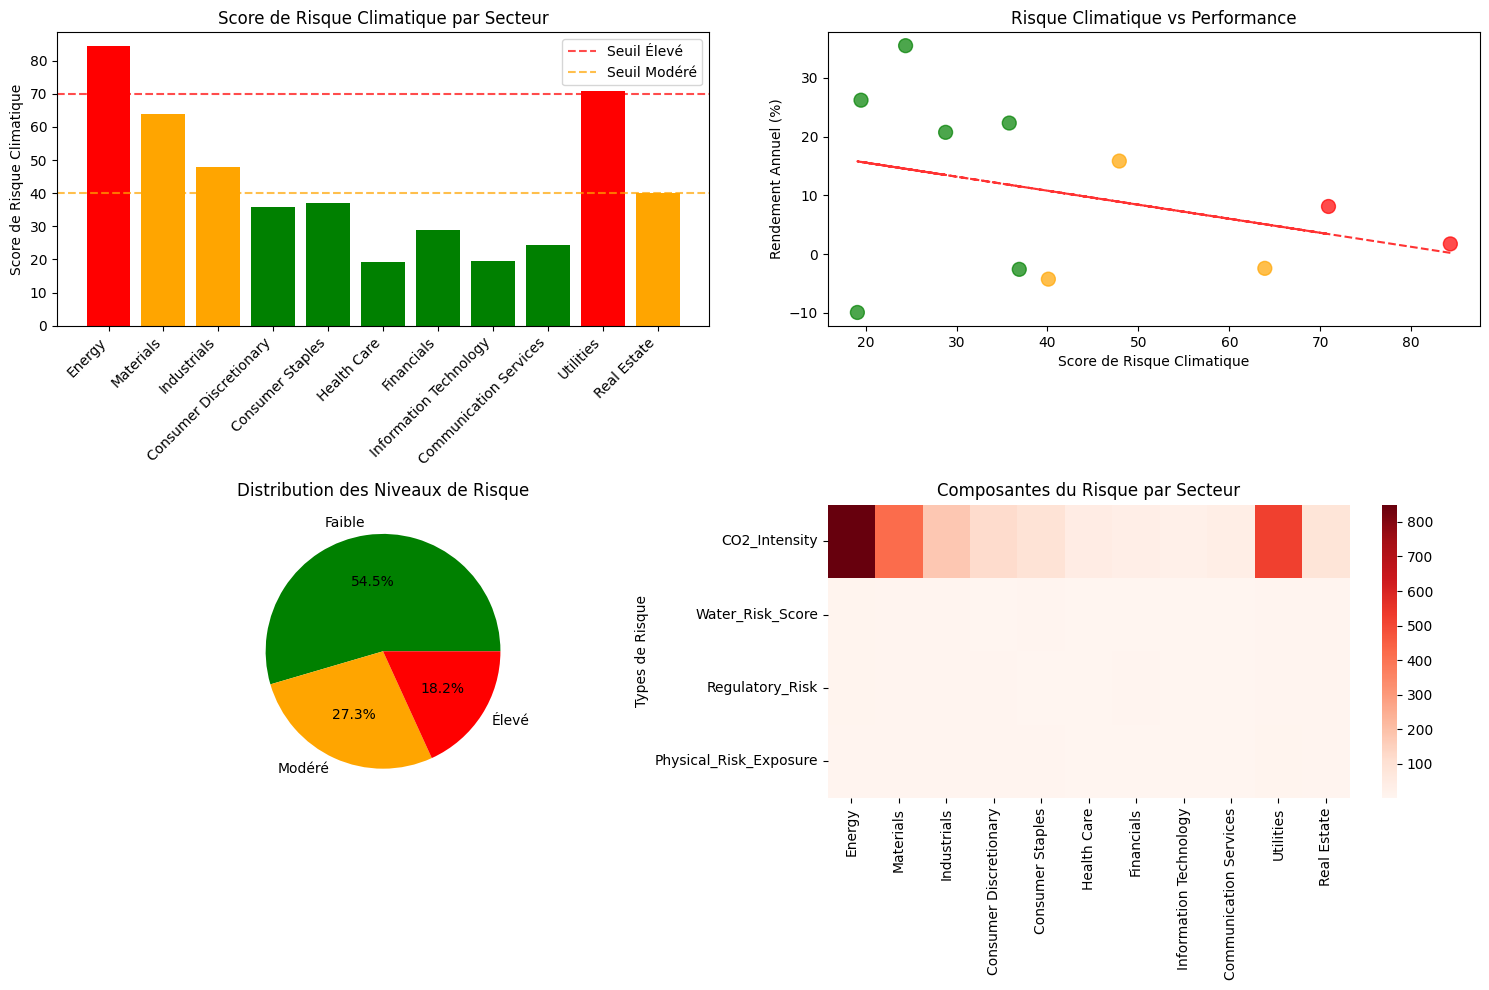


VISUALISATIONS GÉNÉRÉES
Analyse exploratoire terminée


In [7]:
# Visualisations
plt.figure(figsize=(15, 10))

# Subplot 1: Risk Score par secteur
plt.subplot(2, 2, 1)
bars = plt.bar(range(len(df_complete)), df_complete['Climate_Risk_Score'], 
               color=['red' if x >= 70 else 'orange' if x >= 40 else 'green' 
                      for x in df_complete['Climate_Risk_Score']])
plt.xticks(range(len(df_complete)), df_complete['Sector'], rotation=45, ha='right')
plt.ylabel('Score de Risque Climatique')
plt.title('Score de Risque Climatique par Secteur')
plt.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Seuil Élevé')
plt.axhline(y=40, color='orange', linestyle='--', alpha=0.7, label='Seuil Modéré')
plt.legend()

# Subplot 2: Corrélation Risk vs Return
plt.subplot(2, 2, 2)
plt.scatter(df_complete['Climate_Risk_Score'], df_complete['Annual_Return'], 
            c=['red' if x == 'Élevé' else 'orange' if x == 'Modéré' else 'green' 
               for x in df_complete['Risk_Level']], alpha=0.7, s=100)
plt.xlabel('Score de Risque Climatique')
plt.ylabel('Rendement Annuel (%)')
plt.title('Risque Climatique vs Performance')
z = np.polyfit(df_complete['Climate_Risk_Score'], df_complete['Annual_Return'], 1)
p = np.poly1d(z)
plt.plot(df_complete['Climate_Risk_Score'], p(df_complete['Climate_Risk_Score']), "r--", alpha=0.8)

# Subplot 3: Distribution des niveaux de risque
plt.subplot(2, 2, 3)
risk_counts = df_complete['Risk_Level'].value_counts()
colors = {'Faible': 'green', 'Modéré': 'orange', 'Élevé': 'red'}
plt.pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%',
        colors=[colors[level] for level in risk_counts.index])
plt.title('Distribution des Niveaux de Risque')

# Subplot 4: Heatmap des composantes de risque
plt.subplot(2, 2, 4)
risk_components = df_complete[['CO2_Intensity', 'Water_Risk_Score', 
                               'Regulatory_Risk', 'Physical_Risk_Exposure']].T
sns.heatmap(risk_components, annot=False, cmap='Reds', 
            xticklabels=df_complete['Sector'], cbar=True)
plt.title('Composantes du Risque par Secteur')
plt.ylabel('Types de Risque')

plt.tight_layout()
plt.show()

print("\nVISUALISATIONS GÉNÉRÉES")
print("Analyse exploratoire terminée")

In [8]:
# Sauvegarde du dataset final
output_file = 'climate_risk_analysis.csv'
df_complete.to_csv(output_file, index=False)

print(f"\nDATASET SAUVEGARDÉ: {output_file}")
print(f"Colonnes finales: {list(df_complete.columns)}")
print(f"Nombre de secteurs analysés: {len(df_complete)}")

print("\n" + "="*50)
print("ANALYSE TERMINÉE - PRÊT POUR LE DASHBOARD")
print("="*50)


DATASET SAUVEGARDÉ: climate_risk_analysis.csv
Colonnes finales: ['Sector', 'CO2_Intensity', 'Water_Risk_Score', 'Regulatory_Risk', 'Physical_Risk_Exposure', 'Climate_Risk_Score', 'Annual_Return', 'Volatility', 'Risk_Level', 'Risk_Adjusted_Return', 'ESG_Ready']
Nombre de secteurs analysés: 11

ANALYSE TERMINÉE - PRÊT POUR LE DASHBOARD
